In [1]:
from aeon.classification.distance_based import ProximityTree
import numpy as np

from numba import njit

In [8]:
from aeon.datasets import load_italy_power_demand
X, y = load_italy_power_demand(return_type='numpy3d')

In [9]:
clf = ProximityTree(n_splitters = 7)

In [10]:
X_train, X_test = X[:900], X[900:]
y_train, y_test = y[:900],y[900:]
X_test.shape

(196, 1, 24)

In [5]:
X = X.squeeze(axis=1)
X.shape
#X1 = X
X1 = X1.squeeze()
X1.shape

ValueError: cannot select an axis to squeeze out which has size not equal to one

In [5]:
y_train.shape

(900,)

In [11]:
clf.fit(X_train,y_train)

ProximityTree(n_splitters=7)

In [12]:
from sklearn.metrics import accuracy_score

y_pred = clf.predict(X_test)
score = accuracy_score(y_pred, y_test)

In [13]:
score

0.9387755102040817

In [8]:
len(X)

1096

In [6]:
y.ndim

1

In [7]:
X.shape

(1096, 1, 24)

In [8]:
X.reshape((X.shape[0],-1))
X.ndim

3

In [9]:
y = np.array([1,1,2,2,4,4,2,2])
y_subs = [np.array([1,1,4,4]), np.array([2,2,2,2])]
a = np.array([], dtype = y.dtype)
a

array([], dtype=int32)

In [18]:
splitter = clf.get_candidate_splitter(X,y)
len(splitter)

2

In [16]:
X = np.random.rand(10, 50)
X.shape

(10, 50)

In [17]:
y = np.array([1,1,1,2,2,2,0,0,0,1])
y.shape

(10,)

In [20]:
splitter[1].keys()

dict_keys(['lcss'])

In [21]:
from sklearn.utils import check_random_state

In [22]:
random_state = 42
st1 = check_random_state(random_state)

In [23]:
st2 = check_random_state(random_state)

In [24]:
st1

RandomState(MT19937) at 0x1EFF83D0240

In [26]:
st2

RandomState(MT19937) at 0x1EFF83D0840

In [6]:
from numba import njit

@njit(cache=True, fastmath=True)
def gini(y):
        """Get gini score at a specific node.

        Parameters
        ----------
        y : 1d numpy array
            array of class labels

        Returns
        -------
        score : float
            gini score for the set of class labels (i.e. how pure they are). A
            larger score means more impurity. Zero means
            pure.
        """
        # get number instances at node
        n_instances = y.shape[0]
        if n_instances > 0:
            # count each class
            unique_labels = list(np.unique(y))
            class_counts = []
            for i in range(len(unique_labels)):
                cnt = 0
                for j in range(len(y)):
                    if y[j]==unique_labels[i]:
                        cnt += 1
                class_counts.append(cnt)
            class_counts = np.array(class_counts)
            # subtract class entropy from current score for each class
            class_counts = np.divide(class_counts, n_instances)
            class_counts = np.power(class_counts, 2)
            sum = np.sum(class_counts)
            return 1 - sum
        else:
            # y is empty, therefore considered pure
            raise ValueError("y empty")

In [11]:
gini(y)

0.625

In [36]:
unique_class_labels, class_counts = np.unique(y, return_counts=True)
unique_class_labels

array(['1', '2'], dtype='<U1')

In [37]:
class_counts

array([547, 549], dtype=int64)

In [72]:
@njit
def uniques(y):
    unique_labels = list(np.unique(y))
    class_counts = []
    for i in range(len(unique_labels)):
        cnt = 0
        for j in range(len(y)):
            if y[j]==unique_labels[i]:
                cnt += 1
        class_counts.append(cnt)
    unique_labels = np.array(unique_labels)
    class_counts = np.array(class_counts)
    return unique_labels, class_counts

In [73]:
unique_labels, class_counts = uniques(y)

In [74]:
unique_labels

array(['1', '2'], dtype='<U1')

In [62]:
class_counts

array([547, 549], dtype=int64)

In [54]:
y[2]

'2'

In [56]:
for i in range(len(list(np.unique(y)))):
    print(i)

0
1


In [63]:
unique_labels = np.array(np.unique(y))
unique_labels

array(['1', '2'], dtype='<U1')

In [66]:
len(y)

1096

In [9]:
@njit(cache=True, fastmath=True)
def gini_gain(y, y_subs):
        """Get gini score of a split, i.e. the gain from parent to children.

        Parameters
        ----------
        y : 1d array
            array of class labels at parent
        y_subs : list of 1d array like
            list of array of class labels, one array per child

        Returns
        -------
        score : float
            gini score of the split from parent class labels to children. Note a
            higher score means better gain,
            i.e. a better split
        """
        # find number of instances overall
        parent_n_instances = len(y)
        # if parent has no instances then is pure
        if parent_n_instances == 0:
            for child in y_subs:
                if len(child) > 0:
                    raise ValueError("children populated but parent empty")
            return 0.5
        # find gini for parent node
        score = gini(y)
        # sum the children's gini scores
        for index in range(len(y_subs)):
            child_class_labels = y_subs[index]
            # ignore empty children
            if len(child_class_labels) > 0:
                # find gini score for this child
                child_score = gini(child_class_labels)
                # weight score by proportion of instances at child compared to
                # parent
                child_size = len(child_class_labels)
                child_score *= child_size / parent_n_instances
                # add to cumulative sum
                score -= child_score
        return score

In [10]:
y = np.array([1,1,2,2,4,4,2,2])
y_subs = [np.array([1,1,4,4]), np.array([2,2,2,2])]
gini_gain(y,y_subs)

0.375

In [8]:
from aeon.classification.distance_based._proximity_tree import gini_gain
y = np.array([1,1,2,2,4,4,2,2])
y_subs = [np.array([1,1,4,4]), np.array([2,2,2,2])]
gini_gain(y, y_subs)

0.375

In [10]:
len(np.unique(y))

3

In [11]:
np.unique(y)

array([1, 2, 4])

In [80]:
from typing import Type, Union

import numpy as np
from numba import njit
from sklearn.utils import check_random_state

from aeon.classification.base import BaseClassifier
from aeon.distances import distance


class _Node:
    """Proximity Tree node.

    Parameters
    ----------
    node_id: str
        The id of node, root node has id 0.
    _is_leaf: bool
        To identify leaf nodes.
    label: int, str or None
        Contains the class label of leaf node, None otherwise.
    splitter: dict
        The splitter used to split the node.
    class_distribution: dict
        In case of unpure leaf node, save the class distribution to calculate
        probability of each class.
    children: dict
        Contains the class label and the associated node, empty for leaf node.
    """

    def __init__(
        self,
        node_id: str,
        _is_leaf: bool,
        label=None,
        class_distribution=None,
        splitter=None,
    ):
        self.node_id = node_id
        self._is_leaf = _is_leaf
        self.label = label
        self.splitter = splitter
        self.class_distribution = class_distribution or {}
        self.children = {}


class ProximityTree(BaseClassifier):
    """Proximity Tree classifier.

    A Proximity Tree is similar to a decision tree classifier where
    the splits are based on similarity to chosen time series exemplars.
    A Proximity Tree splits the data based on the proximity of each instance to
    each of a set of class exemplars based on a parameterized similarity measure. The
    tree is constructed recursively from the root node down to the leaf nodes.
    At each node (other than leaf nodes) a pool of candidate splitters are evaluated.
    Each splitter has a set of exemplar time series for each class chosen randomly,
    and a parameterized distance measure, also chosen randomly. The splitter that
    maximizes the difference between the Gini impurity of the parent node and the
    weighted sum of Gini impurity of the child nodes.

    Parameters
    ----------
    n_splitters: int, default = 5
        The number of candidate splitters to be evaluated at each node.
    max_depth: int, default = None
        The maximum depth of the tree. If None, then nodes are expanded until all
        leaves are pure or until all leaves contain less than min_samples_split samples.
    min_samples_split: int, default = 2
        The minimum number of samples required to split an internal node.
    random_state : int, RandomState instance or None, default=None
        If `int`, random_state is the seed used by the random number generator;
        If `RandomState` instance, random_state is the random number generator;
        If `None`, the random number generator is the `RandomState` instance used
        by `np.random`.
    n_jobs : int, default = None
        The number of parallel jobs to run for neighbors search.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details. Parameter for compatibility purposes, still unimplemented.

    Notes
    -----
    For the Java version, see
    `ProximityTree
    <https://github.com/fpetitjean/ProximityForest/blob/master/src/trees/ProximityTree.java>`_.

    References
    ----------
    .. [1] Lucas, B., Shifaz, A., Pelletier, C., O’Neill, L., Zaidi, N., Goethals, B.,
    Petitjean, F. and Webb, G.I., 2019. Proximity forest: an effective and scalable
    distance-based classifier for time series. Data Mining and Knowledge Discovery,
    33(3), pp.607-635.

    Examples
    --------
    >>> from aeon.datasets import load_unit_test
    >>> from aeon.classification.distance_based import ProximityTree
    >>> X_train, y_train = load_unit_test(split="train")
    >>> X_test, y_test = load_unit_test(split="test")
    >>> classifier = ProximityTree(n_splitters = 3)
    >>> classifier.fit(X_train, y_train)
    ProximityTree(...)
    >>> y_pred = classifier.predict(X_test)
    """

    _tags = {
        "capability:multivariate": False,
        "capability:unequal_length": False,
        "algorithm_type": "distance",
        "X_inner_type": ["numpy2D"],
    }

    def __init__(
        self,
        n_splitters: int = 5,
        max_depth: int = None,
        min_samples_split: int = 2,
        random_state: Union[int, Type[np.random.RandomState], None] = None,
        n_jobs: int = 1,
    ) -> None:
        self.n_splitters = n_splitters
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.random_state = random_state
        self.n_jobs = n_jobs
        super().__init__()

    def _get_parameter_value(self, X):
        """Generate random parameter values.

        For a list of distance measures, generate a dictionary
        of parameterized distances.

        Parameters
        ----------
        X : np.ndarray of shape (n_cases, n_timepoints)

        Returns
        -------
        distance_param : a dictionary of distances and their
        parameters.
        """
        rng = check_random_state(self.random_state)

        X_std = X.std()
        param_ranges = {
            "euclidean": {},
            "dtw": {"window": (0, 0.25)},
            "ddtw": {"window": (0, 0.25)},
            "wdtw": {"g": (0, 1)},
            "wddtw": {"g": (0, 1)},
            "erp": {"g": (X_std / 5, X_std)},
            "lcss": {"epsilon": (X_std / 5, X_std), "window": (0, 0.25)},
        }
        random_params = {}
        for measure, ranges in param_ranges.items():
            random_params[measure] = {
                param: np.round(rng.uniform(low, high), 3)
                for param, (low, high) in ranges.items()
            }
        # For TWE
        lmbda = rng.randint(0, 9)
        exponent_range = np.arange(1, 6)  # Exponents from -5 to 1 (inclusive)
        random_exponent = rng.choice(exponent_range)
        nu = 1 / 10**random_exponent
        random_params["twe"] = {"lmbda": lmbda, "nu": nu}

        # For MSM
        base = 10
        # Exponents from -2 to 2 (inclusive)
        exponents = np.arange(-2, 3, dtype=np.float64)
        # Randomly select an index from the exponent range
        random_index = rng.randint(0, len(exponents))
        c = base ** exponents[random_index]
        random_params["msm"] = {"c": c}

        return random_params

    def _get_candidate_splitter(self, X, y):
        """Generate candidate splitter.

        Takes a time series dataset and a set of parameterized
        distance measures to create a candidate splitter, which
        contains a parameterized distance measure and a set of exemplars.

        Parameters
        ----------
        X : np.ndarray shape (n_cases, n_timepoints)
            The training input samples.
        y : np.array shape (n_cases,) or (n_cases,1)
            The labels of the training samples.
        parameterized_distances : dictionary
            Contains the distances and their parameters.

        Returns
        -------
        splitter : list of two dictionaries
            A distance and its parameter values and a set of exemplars.
        """
        rng = check_random_state(self.random_state)
            
        exemplars = {}
        for label in range(len(classes_)):
            id = rng.randint(0, self.class_locs_[label].shape[0])
            exemplars[label] = X[id, :]

        # Create a list with first element exemplars and second element a
        # random parameterized distance measure
        parameterized_distances = self._get_parameter_value(X)
        n = rng.randint(0, 9)
        dist = list(parameterized_distances.keys())[n]
        splitter = [exemplars, {dist: parameterized_distances[dist]}]

        return splitter

    def _get_best_splitter(self, X, y):
        """Get the splitter for a node which maximizes the gini gain."""
        max_gain = float("-inf")
        best_splitter = None
        for _ in range(self.n_splitters):
            splitter = self._get_candidate_splitter(X, y)
            labels = list(splitter[0].keys())
            measure = list(splitter[1].keys())[0]
            y_subs = [[] for _ in range(len(labels))]
            for j in range(X.shape[0]):
                min_dist = float("inf")
                sub = None
                for k in range(len(labels)):
                    dist = distance(
                        X[j],
                        splitter[0][labels[k]],
                        metric=measure,
                        kwargs=splitter[1][measure],
                    )
                    if dist < min_dist:
                        min_dist = dist
                        sub = k
                y_subs[sub].append(y[j])
            y_subs = [np.array(ele, dtype=y.dtype) for ele in y_subs]
            gini_index = gini_gain(y, y_subs)
            if gini_index > max_gain:
                max_gain = gini_index
                best_splitter = splitter
        return best_splitter

    def _build_tree(self, X, y, depth, node_id, parent_target_value=None):

        # If the data reaching the node is empty
        if len(X) == 0:
            leaf_label = parent_target_value
            leaf_distribution = {}
            leaf = _Node(
                node_id=node_id,
                _is_leaf=True,
                label=leaf_label,
                class_distribution=leaf_distribution,
            )
            return leaf

        # Target value in current node
        target_value = self._find_target_value(y)
        class_distribution = {
            label: count / len(y)
            for label, count in zip(*np.unique(y, return_counts=True))
        }

        # If min sample splits is reached
        if self.min_samples_split >= len(X):
            leaf_label = target_value
            leaf = _Node(
                node_id=node_id,
                _is_leaf=True,
                label=leaf_label,
                class_distribution=class_distribution,
            )
            return leaf

        # If max depth is reached
        if (self.max_depth is not None) and (depth >= self.max_depth):
            leaf_label = target_value
            leaf = _Node(
                node_id=node_id,
                _is_leaf=True,
                label=leaf_label,
                class_distribution=class_distribution,
            )
            return leaf

        # Pure node
        if len(np.unique(y)) == 1:
            leaf_label = target_value
            leaf = _Node(
                node_id=node_id,
                _is_leaf=True,
                label=leaf_label,
                class_distribution=class_distribution,
            )
            return leaf

        # Find the best splitter
        splitter = self._get_best_splitter(X, y)

        # Create root node
        node = _Node(node_id=node_id, _is_leaf=False, splitter=splitter)

        # For each exemplar split the data
        labels = list(splitter[0].keys())
        measure = list(splitter[1].keys())[0]
        X_child = [[] for _ in labels]
        y_child = [[] for _ in labels]
        for i in range(len(X)):
            min_dist = np.inf
            id = None
            for j in range(len(labels)):
                dist = distance(
                    X[i],
                    splitter[0][labels[j]],
                    metric=measure,
                    kwargs=splitter[1][measure],
                )
                if dist < min_dist:
                    min_dist = dist
                    id = j
            X_child[id].append(X[i])
            y_child[id].append(y[i])
        X_child = [np.array(ele) for ele in X_child]
        y_child = [np.array(ele) for ele in y_child]
        # For each exemplar, create a branch
        for i in range(len(labels)):
            child_node_id = node_id + "." + str(i)
            child_node = self._build_tree(
                X_child[i],
                y_child[i],
                depth=depth + 1,
                node_id=child_node_id,
                parent_target_value=target_value,
            )
            node.children[labels[i]] = child_node

        return node

    @staticmethod
    @njit(cache=True, fastmath=True)
    def _find_target_value(y):
        """Get the class label of highest frequency."""
        unique_labels = list(np.unique(y))
        class_counts = []
        for i in range(len(unique_labels)):
            cnt = 0
            for j in range(len(y)):
                if y[j] == unique_labels[i]:
                    cnt += 1
            class_counts.append(cnt)
        class_counts = np.array(class_counts)
        # Find the index of the maximum count
        max_index = np.argmax(class_counts)
        mode_value = unique_labels[max_index]
        # mode_count = counts[max_index]
        return mode_value

    def _fit(self, X, y):
        # Set the unique class labels
        if (X.ndim != 2) or (y.ndim != 1):
            raise ValueError("X should be of shape (n_cases, n_timepoints).")
            
        self.classes_ = list(np.unique(y))
        self.class_locs_ = []
        for label in self.classes_:
            self.class_locs_.append(np.where(y==label)[0]) # use [0] as y is 1D
        self.root = self._build_tree(
            X, y, depth=0, node_id="0", parent_target_value=None
        )

    def _predict(self, X):
        probas = self._predict_proba(X)
        predictions = np.argmax(probas, axis=1)
        return np.array([self.classes_[pred] for pred in predictions])

    def _predict_proba(self, X):
        # Get the unique class labels
        classes = self.classes_
        class_count = len(classes)
        probas = []

        for i in range(len(X)):
            # Classify the data point and find the leaf node
            leaf_node = self._classify(self.root, X[i])

            # Create probability distribution based on class counts in the leaf node
            proba = np.zeros(class_count)
            for class_label, class_proba in leaf_node.class_distribution.items():
                proba[classes.index(class_label)] = class_proba
            probas.append(proba)

        return np.array(probas)

    def _classify(self, treenode, x):
        # Classify one data point using the proximity tree
        if treenode._is_leaf:
            return treenode
        else:
            measure = list(treenode.splitter[1].keys())[0]
            branches = list(treenode.splitter[0].keys())
            min_dist = np.inf
            id = None
            for i in range(len(branches)):
                dist = distance(
                    x,
                    treenode.splitter[0][branches[i]],
                    metric=measure,
                    kwargs=treenode.splitter[1][measure],
                )
                if dist < min_dist:
                    min_dist = dist
                    id = i
            return self._classify(treenode.children[branches[id]], x)


@njit(cache=True, fastmath=True)
def gini(y) -> float:
    """Get gini score at a specific node.

    Parameters
    ----------
    y : 1d numpy array
        array of class labels

    Returns
    -------
    score : float
        gini score for the set of class labels (i.e. how pure they are). A
        larger score means more impurity. Zero means
        pure.
    """
    # get number instances at node
    n_instances = y.shape[0]
    if n_instances > 0:
        # count each class
        unique_labels = list(np.unique(y))
        class_counts = []
        for i in range(len(unique_labels)):
            cnt = 0
            for j in range(len(y)):
                if y[j] == unique_labels[i]:
                    cnt += 1
            class_counts.append(cnt)
        class_counts = np.array(class_counts)
        # subtract class entropy from current score for each class
        class_counts = np.divide(class_counts, n_instances)
        class_counts = np.power(class_counts, 2)
        sum = np.sum(class_counts)
        return 1 - sum
    else:
        # y is empty, therefore considered pure
        raise ValueError("y empty")


@njit(cache=True, fastmath=True)
def gini_gain(y, y_subs) -> float:
    """Get gini score of a split, i.e. the gain from parent to children.

    Parameters
    ----------
    y : 1d array
        array of class labels at parent
    y_subs : list of 1d array like
        list of array of class labels, one array per child

    Returns
    -------
    score : float
        gini score of the split from parent class labels to children. Note a
        higher score means better gain,
        i.e. a better split
    """
    # find number of instances overall
    parent_n_instances = y.shape[0]
    # if parent has no instances then is pure
    if parent_n_instances == 0:
        for child in y_subs:
            if len(child) > 0:
                raise ValueError("children populated but parent empty")
        return 0.5
    # find gini for parent node
    score = gini(y)
    # sum the children's gini scores
    for index in range(len(y_subs)):
        child_class_labels = y_subs[index]
        # ignore empty children
        if len(child_class_labels) > 0:
            # find gini score for this child
            child_score = gini(child_class_labels)
            # weight score by proportion of instances at child compared to
            # parent
            child_size = len(child_class_labels)
            child_score *= child_size / parent_n_instances
            # add to cumulative sum
            score -= child_score
    return score


In [81]:
clf1 = ProximityTree(n_splitters = 7, max_depth = 6)

In [82]:
clf1._fit(X_train, y_train)

IndexError: index 197 is out of bounds for axis 0 with size 131

In [42]:
from sklearn.metrics import accuracy_score

y_pred = clf1._predict(X_test)
score = accuracy_score(y_pred, y_test)

In [43]:
score

0.9438775510204082

In [2]:
from aeon.datasets import load_unit_test
from aeon.classification.distance_based import ProximityTree
X_train, y_train = load_unit_test(split="train")
X_test, y_test = load_unit_test(split="test")
classifier = ProximityTree(n_splitters = 3, max_depth = 5)
classifier.fit(X_train, y_train)

ProximityTree(max_depth=5, n_splitters=3)

In [8]:
@njit(cache=True, fastmath=True)
def _find_target_value(y):
        """Get the class label of highest frequency."""
        unique_labels = list(np.unique(y))
        class_counts = []
        for i in range(len(unique_labels)):
            cnt = 0
            for j in range(len(y)):
                if y[j] == unique_labels[i]:
                    cnt += 1
            class_counts.append(cnt)
        class_counts = np.array(class_counts)
        # Find the index of the maximum count
        max_index = np.argmax(class_counts)
        mode_value = unique_labels[max_index]
        # mode_count = counts[max_index]
        return mode_value

In [10]:
_find_target_value(y)

'2'

In [5]:
np.unique(y, return_counts=True)

(array(['1', '2'], dtype='<U1'), array([547, 549], dtype=int64))

In [6]:
   def _find_target_value(y):
        """Get the class label of highest frequency."""
        unique, counts = np.unique(y, return_counts=True)
        # Find the index of the maximum count
        max_index = np.argmax(counts)
        mode_value = unique[max_index]
        # mode_count = counts[max_index]
        return mode_value

In [7]:
_find_target_value(y)

'2'

In [18]:
clf1._get_candidate_splitter(X_train,y_train)

[{'1': array([-0.29671594, -0.79984296, -0.95465128, -1.2642679 , -1.4190762 ,
         -1.4964804 , -1.0320554 , -0.64503465, -0.99335336, -0.14190762,
          0.32251732,  0.3612194 ,  0.59343188,  0.24511317, -0.33541802,
         -0.29671594, -0.33541802,  0.94175059,  1.4448776 ,  1.7931963 ,
          1.8318984 ,  1.3287714 ,  0.78694227,  0.3612194 ]),
  '2': array([ 0.38587292, -0.08502285, -1.0268144 , -1.2361014 , -1.2884231 ,
         -1.1837796 , -0.97449262, -1.3930666 , -0.60824036,  0.17658591,
          0.38587292,  0.75212517,  0.54283817,  0.01962066, -0.1373446 ,
         -0.55591861, -0.55591861, -0.55591861,  0.07194241,  1.7985602 ,
          2.1124907 ,  1.5892732 ,  1.1706992 ,  0.59515992])},
 {'erp': {'g': 0.491}}]

In [23]:
classes_ = list(np.unique(y))
class_locs_ = []
for label in classes_:
    class_locs_.append(np.where(y==label)[0]) # use [0] as y is 1D

In [24]:
len(classes_)

2

In [25]:
len(class_locs_)

2

In [27]:
len(class_locs_[1])

549

In [34]:
exemplars = {}
for label in range(len(classes_)):
    id = np.random.randint(0, class_locs_[label].shape[0])
    exemplars[label] = X[id, :]

In [35]:
exemplars

{0: array([-1.1178645 , -1.4190694 , -1.505128  , -1.6342158 , -1.6557304 ,
        -1.505128  , -1.0102914 ,  0.04392572,  0.4742184 ,  1.0335989 ,
         1.0551135 ,  0.969055  ,  0.8399672 ,  0.49573304,  0.4096745 ,
         0.60330622,  0.5387623 ,  0.58179157,  0.81845256,  1.2487452 ,
         0.79693793,  0.45270377, -0.02061819, -0.49394015]),
 1: array([ 0.33926348, -0.32541599, -0.71314569, -0.93470552, -1.1008754 ,
        -1.1008754 , -0.87931556, -0.54697582, -0.99009547, -0.32541599,
         0.28387353,  0.61621327,  0.50543335,  0.11770366, -0.38080595,
        -0.54697582, -0.71314569, -0.71314569, -0.38080595,  0.4500434 ,
         2.3886919 ,  2.0563521 ,  1.7240124 ,  1.1701128 ])}

In [56]:
X1 = np.random.uniform(0,2, size = 500).reshape((50,10))
X1[5]

array([1.85774544, 0.4315754 , 1.83557252, 1.03927471, 1.50690448,
       1.2610533 , 0.64689672, 0.89479119, 1.86570593, 0.99634836])

In [58]:
X2 = np.random.uniform(3,5, size = 500).reshape((50,10))
X2[0]

array([4.4524013 , 3.98640968, 4.91235267, 3.24272041, 3.68691933,
       4.38410718, 4.88167147, 3.43756319, 4.85451838, 3.23610597])

In [47]:
y1 = np.full((50,), '0')
y2 = np.full((50,), '1')
y = np.concatenate((y1,y2), axis=0)
y.shape

(100,)

In [55]:
random_ints = np.random.uniform(0,1, size=5)
random_ints

array([0.39939819, 0.85966705, 0.69619281, 0.28313637, 0.34090891])

In [59]:
X = np.concatenate((X1,X2), axis=0)
X.shape

(100, 10)

In [60]:
clf = ProximityTree()
clf.fit(X,y)

ProximityTree()

In [61]:
y_pred = clf.predict(X)
accuracy_score(y_pred,y)

1.0

In [64]:
X_test1 = np.random.uniform(0,3, size = 50).reshape(5,10)
X_test2 = np.random.uniform(1,6, size = 50).reshape(5,10)
X_test = np.concatenate((X_test2, X_test1), axis=0)

In [65]:
y_test1= np.full((5,),'0')
y_test2=np.full((5,),'1')
y_test = np.concatenate((y_test2, y_test1), axis=0)

In [66]:
y_pred = clf.predict(X_test)
accuracy_score(y_pred,y_test)

1.0

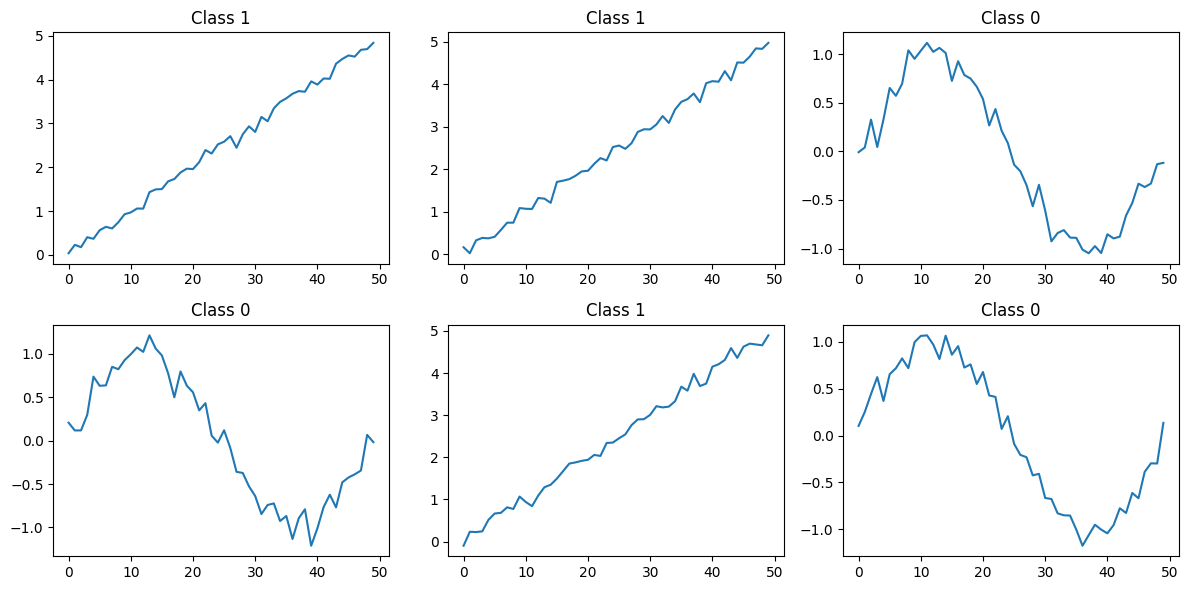

In [67]:
import numpy as np
import matplotlib.pyplot as plt

def generate_sinusoidal(length, freq, amplitude, noise_level=0.1):
    t = np.linspace(0, 2 * np.pi, length)
    signal = amplitude * np.sin(freq * t)
    noise = noise_level * np.random.randn(length)
    return signal + noise

def generate_linear(length, slope, intercept, noise_level=0.1):
    t = np.linspace(0, length-1, length)
    signal = slope * t + intercept
    noise = noise_level * np.random.randn(length)
    return signal + noise

def create_time_series_dataset(n_samples, length):
    data = []
    labels = []
    
    for _ in range(n_samples // 2):
        # Generate sinusoidal time series
        sinusoidal = generate_sinusoidal(length, freq=1, amplitude=1)
        data.append(sinusoidal)
        labels.append(0)
        
        # Generate linear time series
        linear = generate_linear(length, slope=0.1, intercept=0)
        data.append(linear)
        labels.append(1)
        
    data = np.array(data)
    labels = np.array(labels)
    
    # Shuffle the dataset
    indices = np.random.permutation(n_samples)
    data = data[indices]
    labels = labels[indices]
    
    return data, labels

# Parameters
n_samples = 100  # Total number of samples (should be even)
length = 50      # Length of each time series

# Generate the dataset
data, labels = create_time_series_dataset(n_samples, length)

# Plot a few examples
plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.plot(data[i])
    plt.title(f'Class {labels[i]}')
plt.tight_layout()
plt.show()


In [68]:
data.shape

(100, 50)

In [69]:
labels.shape

(100,)

In [70]:
np.unique(labels)

array([0, 1])

In [76]:
X, y = create_time_series_dataset(200, 20)
X_test, y_test = create_time_series_dataset(50,20)

In [77]:
clf.fit(X,y)
y_pred = clf.predict(X_test)
accuracy_score(y_pred,y_test)

1.0

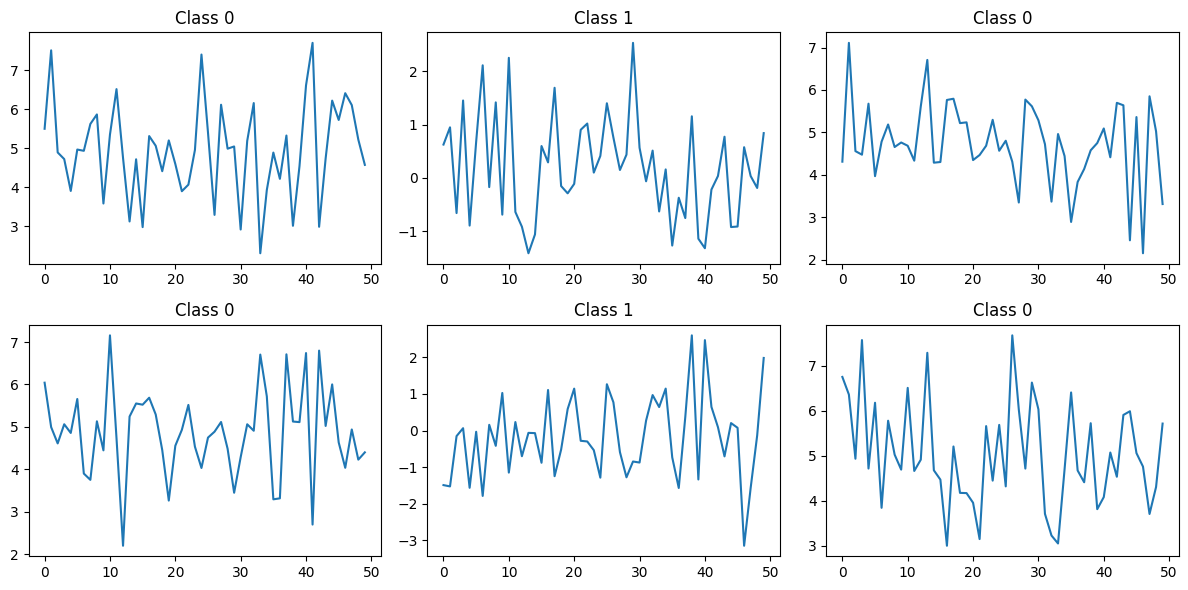

In [75]:
import numpy as np
import matplotlib.pyplot as plt

def generate_time_series(length, mean, std, noise_level=0.5):
    signal = np.random.normal(mean, std, length)
    noise = noise_level * np.random.randn(length)
    return signal + noise

def create_time_series_dataset(n_samples, length):
    data = []
    labels = []
    
    half_samples = n_samples // 2
    
    for _ in range(half_samples):
        # Generate time series with larger values for class 0
        larger_values = generate_time_series(length, mean=5, std=1)
        data.append(larger_values)
        labels.append(0)
        
        # Generate time series with smaller values for class 1
        smaller_values = generate_time_series(length, mean=0, std=1)
        data.append(smaller_values)
        labels.append(1)
        
    data = np.array(data)
    labels = np.array(labels)
    
    # Shuffle the dataset
    indices = np.random.permutation(n_samples)
    data = data[indices]
    labels = labels[indices]
    
    return data, labels

# Parameters
n_samples = 100  # Total number of samples (should be even)
length = 50      # Length of each time series

# Generate the dataset
data, labels = create_time_series_dataset(n_samples, length)

# Plot a few examples
plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.plot(data[i])
    plt.title(f'Class {labels[i]}')
plt.tight_layout()
plt.show()


In [8]:
from aeon.testing.data_generation import make_example_3d_numpy
X,y = make_example_3d_numpy(10,1,12, n_labels=2)
X

array([[[0.        , 1.69159304, 1.08804603, 1.8110271 , 0.03137393,
         0.27883059, 1.77809095, 0.94104588, 1.3680432 , 1.32962947,
         1.82753881, 0.1513075 ]],

       [[2.        , 0.59719574, 2.11801394, 3.75080261, 2.13844945,
         3.41104566, 0.00513538, 1.5321236 , 1.78017574, 3.07773445,
         3.88894289, 2.31999879]],

       [[2.86246869, 3.75752345, 0.50850668, 3.75833246, 0.30529557,
         2.81106939, 0.0080994 , 1.07327084, 2.07509781, 3.01818843,
         3.65197881, 2.75775313]],

       [[0.06329563, 0.42992183, 0.83740157, 0.24286289, 0.11677167,
         0.5559328 , 0.05797565, 1.2293005 , 1.66042437, 0.93560231,
         1.43117326, 1.33586495]],

       [[2.18646506, 0.27136109, 3.73639709, 0.78924571, 3.02347717,
         1.07473634, 2.69399758, 3.85864114, 2.67097721, 3.05390851,
         2.95591651, 1.29168201]],

       [[3.44631609, 3.80359998, 1.39283666, 0.32064672, 0.89076124,
         3.56894501, 0.11563305, 0.63427849, 0.70756362, 2.80

In [9]:
y

array([0, 1, 1, 0, 1, 1, 1, 1, 0, 0])